### PPOL 564 - Coding Discussion #4<br/>Ryan Ripper<br/>11/7/21

In [1]:
# Import the necessary Python Modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In order to analyze differences between the five articles, we will create functions that will prepare a Document-Term Matrix that will hold individual word counts. We will then calculate the cos(theta) between each combination of article in order to determine which news sites report on this topic in similar and dissimilar ways.

In [2]:
# Create function that converts the text of a news article to a list of words (strings).
def tokenize_text(full_text = None, remove_words = None):
    """
    The tokenize_text function converts a string to a list of words, removing stop words and any additional words.
    
    Arguments
    -----
    full_text: string
        A string containing text to be split into a list.
        
    remove_words: list
        A list containing words to be removed from the final list of words.
    
    return
    -----
    A list where the entries are strings of words from the original text.
    """
    
    # Load in stopwords from associated CSV.
    stopwords = pd.read_csv("../Data/stop_words.csv")
    
    # Convert Pandas DataFrame to a list to be handled in list comprehension.
    stopwords = stopwords["word"].to_list()
    
    # If there are additional words to remove, then add them to the stopwords to be removed.
    if remove_words != None:
        stopwords.extend(remove_words)

    # Make the text all lower-case.
    full_text = full_text.lower()
    
    # Remove punctuation from text.
    full_text = (full_text
                 .replace('.', '') # Remove periods.
                 .replace('"', '') # Remove quotation marks.
                 .replace('“', '') # Remove special quotation marks.
                 .replace('(', '') # Remove left parentheses.
                 .replace(')', '') # Remove right parentheses.
                 .replace(',', '') # Remove commas.
                 .replace('-', '') # Remove hyphen.
                 .replace('—', '') # Remove long hyphen.
                 .replace('\'', '') # Remove apostrophe.
                )
    
    # Split the text by spaces into a list of words.
    full_text_list = full_text.split()
    
    # If the word is not one of the stopwords, then add to new list.
    full_text_list2 = [word for word in full_text_list if word not in stopwords]
    
    # Return list of words that are not stopwords from the text.
    return full_text_list2

In [3]:
# Create function to convert a list of words (strings) to a DTM.
def text_to_dtm(text_list = None, remove_words = None):
    """
    The text_to_dtm function creates a Document-Term Matrix from a list of words.
    
    Arguments
    -----
    text_list: list
        A list where the entries are strings of words.
        
    remove_words: list
        A list containing words to be removed from the Document-Term Matrix.
        
    return
    -----
    A Document-Term Matrix in the form of a Pandas DataFrame for a list of words.
    """

    # Create empty dictionary where key will be word and value will be a list with the count of the word in the text.
    final_dict = dict()

    # Iterate through each word in the list of words from the text.
    for word in tokenize_text(text_list, remove_words):
        # If the word is already in the dictionary, add 1 to the count of the word.
        if word in final_dict:
            final_dict[word][0] += 1
        # Otherwise, add word to dictionary with count 1.
        else:
            final_dict[word] = [1]

    # Return the dictionary as a Pandas DataFrame.
    return pd.DataFrame(final_dict)

In [4]:
# Create function that takes the results from the above functions and builds the final DTM for all news articles.
def create_dtm(texts_dict = None, remove_words = None):
    """
    The create_dtm function createa a Document-Term Matrix for a dictionary of articles.
    
    Arguments
    -----
    texts_dict: dictionary
        A dictionary where the keys represent the sources of the articles and the values are the corresponding paths.
        
    remove_words: list
        A list containing words to be removed from the final Document-Term Matrix.
        
    return
    -----
    A Document-Term Matrix in the form of a Pandas DataFrame for all articles in the dictionary.
    """

    # Create empty Pandas DataFrame to hold Document-Term Matrix (DTM).
    dtm = pd.DataFrame()

    # For each text in the dictionary of text files.
    for text in texts_dict:
        # Open the file from the dictionary where the key is the file source and the value is the file path.
        file = open(texts_dict[text], mode = "rt", encoding = "UTF-8")
        
        # Read the file as text.
        file_text = file.read()
        
        # Close the file.
        file.close()
        
        # Convert the text of the file to a DTM.
        entry = text_to_dtm(file_text, remove_words)
        
        # Add the DTM we created from the text within the file to the final Pandas DataFrame with all DTMs.
        dtm = dtm.append(pd.DataFrame(entry), ignore_index = True, sort = True)
    
    # Fill all NA values with 0.
    dtm.fillna(0, inplace = True)
    
    # Change the index of the rows to the keys of the dictionary of text files.
    dtm.index = list(texts_dict.keys())

    # Return the final DTM.
    return dtm

In [5]:
# Create function that calculates the cos(theta) value of two vectors.
def cosine(a, b):
    """
    The cosine function calculates the cos(theta) value between two vectors.
    
    Arguments
    -----
    a: list/vector
        A list/vector of words for an article.
        
    b: list/vector
        A list/vector of words for an article.
        
    return
    -----
    A float value representing the cos(theta) between vector a and vector b.
    """
    
    # Calculate cos(theta) for vector a and vector b.
    cos = np.dot(a, b) / (np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b, b)))
    
    # Return cos(theta).
    return cos

In [6]:
# Create function that calculates the cos(theta) between each article and visualizes the results as a heatmap.
def visualize_cos(texts_dict = None, remove_words = None):
    """
    The visualize_cos function creates a heat-map representing cos(theta) between each article in a dictionary.
    
    Arguments
    -----
    texts_dict: dictionary
        A dictionary where the keys represent the sources of the articles and the values are the corresponding paths.
        
    remove_words: list
        A list containing words to be removed from the vectors used to calculate cos(theta) values.
    
    return
    -----
    A Pandas DataFrame containing the cosine(theta) values for every combination of article.
    """
    
    # Prepare the Document-Term Matrix for the dictionary of articles.
    D = create_dtm(texts_dict, remove_words)
    
    # Store the number of articles to be evaluated.
    num_articles = len(texts_dict.keys())
    
    # Create empty Pandas DataFrame of zeros where size of the square matrix is the number of keys in the dictionary.
    cos_mtx = pd.DataFrame(np.zeros((num_articles, num_articles)), # Create square matrix of zeros.
                           columns = text_srcs.keys(), # Set column names to the keys of the dictionary.
                           index = text_srcs.keys()) # Set index names to the keys of the dictionary.
    
    # Iterate through each article.
    for news_a in list(cos_mtx.columns):
        # Iterate through each article against every other article.
        for news_b in list(cos_mtx.index):
            # Calculate the cos(theta) between each combination of article.
            cos = cosine(D.loc[news_a], D.loc[news_b])
            
            # Store the cos(theta) in the Pandas DataFrame.
            cos_mtx.loc[news_a, news_b] = cos
    
    # Plot the dataframe containing cos(theta) between each combination of article.
    plt.imshow(cos_mtx, cmap = "gray_r", interpolation = "nearest")
    
    # Show and style the color bar to understand the heatmap.
    cbar = plt.colorbar()
    
    # Change the fontsize of the colorbar.
    cbar.ax.tick_params(labelsize = 15)
    
    # Set the text and change the fontsize of the colorbar label.
    cbar.set_label(label = "cos(θ)", size = 15)
    
    # Define the x and y ticks for the plot. The number of articles creates a range to apply the x and y ticks.
    plt.xticks(range(num_articles), list(cos_mtx.columns), size = 15, rotation = "vertical")
    plt.yticks(range(num_articles), list(cos_mtx.index), size = 15)
    
    # Set the title of the plot.
    title = "Cos(θ) Visualization for Each Article Combination"
    
    # If removing additional words, change title.
    if remove_words != None:
        title += "\nwith Additional Words Removed"
        
    # Add the title to the plot and change the size and padding of the text.
    plt.title(title, size = 20, pad = 20)
    
    # Show the plot.
    plt.show()
    
    # Also return the matrix with cos(theta) results.
    return cos_mtx

In [7]:
# Create dictionary where key is the news source and the value is the path to the associated text file.
text_srcs = {
    "Aljazeera": "../Data/aljazeera-khashoggi.txt",
    "BBC": "../Data/bbc-khashoggi.txt",
    "Breitbart": "../Data/breitbart-khashoggi.txt",
    "CNN": "../Data/cnn-khashoggi.txt",
    "Fox": "../Data/fox-khashoggi.txt"
}

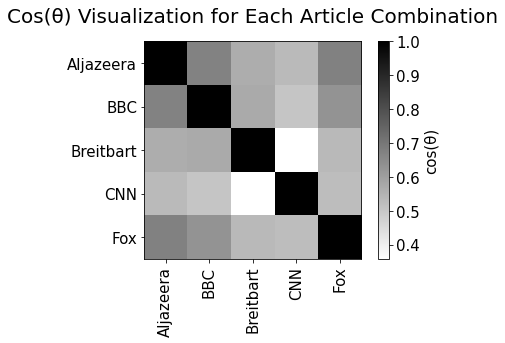

,Aljazeera,BBC,Breitbart,CNN,Fox
Aljazeera,1.000000,0.672549,0.564952,0.531017,0.675539
BBC,0.672549,1.000000,0.573017,0.504205,0.629934
Breitbart,0.564952,0.573017,1.000000,0.357928,0.535168
CNN,0.531017,0.504205,0.357928,1.000000,0.525179
Fox,0.675539,0.629934,0.535168,0.525179,1.000000


In [8]:
# Visualize cos(theta) between each combination of articles in order to observe how similar/dissimilar they are.
visualize_cos(text_srcs)

In order to understand how similar or dissimilar an article is, we calculate the cos(theta) values between two articles where we have converted each article to a vector of words. We observe values of cos(theta) between 0 and 1. If cos(theta) is close to 0, then theta is close to 90 degrees, meaning the two vectors are close to orthogonal, or are not similar. If cos(theta) is close to 1, then theta is close to 0 degrees, meaning the two vectors are close to mapping directly onto one another, or are similar.

In the case of comparing articles to how they cover the Turkish President Erdogan addressing the murder of journalist Jamal Khashoggi, we observe that most of the news sites report on the topic in a similar way since we see values of cos(theta) closer to 1.

Fox, the BBC, and Aljazeera use similar words in their articles since they have higher cos(theta) values across the three news sources when compared to the other articles.

We observe that CNN and Breitbart are the most dissimilar in our analysis where they share the lowest cos(theta) value across all combinations of articles.

We can potentially understand how each article addresses the topic based on each news sources' tendency to either lean to the left or to the right when reporting. For example, the dissimilarity between CNN and Breitbart can be attributed to the left-leaning CNN reporting versus the right-leaning Breitbart reporting.

In [9]:
# We now change the words to remove and then observe the cos(theta) between each combination of articles again.

# Create the DTM.
DTM = create_dtm(text_srcs)

# Collect the top 10 used words across all the articles to be removed.
remove_words = (DTM
                .sum(axis = 0) # Sum count for each word across all articles.
                .sort_values(ascending = False) # Sort count in descending order.
                .head(10) # Take the top 10 words.
                .index # Identify the words, not the counts.
                .to_list() # Convert to a list.
               )

# Observe the top 10 used words across all the articles.
print(remove_words)

['saudi', 'erdogan', 'khashoggi', 'turkish', 'consulate', 'president', 'killing', 'murder', 'istanbul', 'arabia']


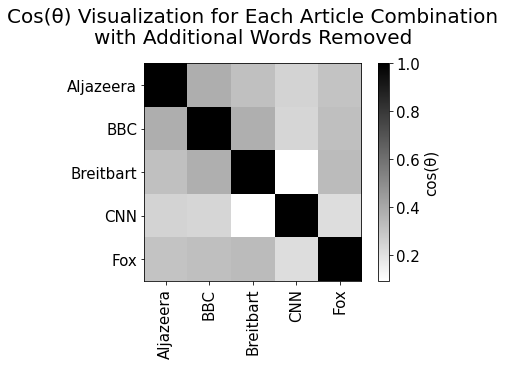

,Aljazeera,BBC,Breitbart,CNN,Fox
Aljazeera,1.000000,0.381698,0.316292,0.247578,0.302270
BBC,0.381698,1.000000,0.377015,0.241055,0.321910
Breitbart,0.316292,0.377015,1.000000,0.092827,0.335328
CNN,0.247578,0.241055,0.092827,1.000000,0.214599
Fox,0.302270,0.321910,0.335328,0.214599,1.000000


In [10]:
# Visualize cos(theta) between each combination of articles while removing the top 10 words used in all articles.
visualize_cos(text_srcs, remove_words)

If we remove the top 10 used words across all the articles, not considering the stop words, we observe that the cos(theta) values change across the board. The values appear to decrease for every combination of article once we remove these words. The words we removed are specific to this bulletin where they would not be used outside this particular topic. Thus, once we remove these words, the articles are much more dissimilar since they no longer share keywords that are particular to the murder of journalist Jamal Khashoggi. We do see that Breitbart and CNN continue to differ significantly where our assumption that articles are written with political preferences in consideration still holds.